In [4]:
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization
from keras.layers import GlobalAveragePooling2D

os.listdir("dataset")

Using TensorFlow backend.


['Test', 'Train']

In [6]:
len(os.listdir("dataset/Train/Covid19 Positive"))

2532

In [7]:
train_dir = "dataset/Train"
test_dir = "dataset/Test"


print("Train set:\n========================================")
num_Covid19_Positive = len(os.listdir(os.path.join(train_dir, 'Covid19 Positive')))
num_Covid19_Negative = len(os.listdir(os.path.join(train_dir, 'Covid19 Negative')))
Pneumonia = len(os.listdir(os.path.join(train_dir, 'Pneumonia')))
print(f"Covid19 Positive={num_Covid19_Positive}")
print(f"Covid19 Negative={num_Covid19_Negative}")
print(f"Pneumonia={Pneumonia}")

print("Test set:\n========================================")
print(f"Covid19 Positive={len(os.listdir(os.path.join(test_dir, 'Covid19 Positive')))}")
print(f"Covid19 Negative={len(os.listdir(os.path.join(test_dir, 'Covid19 Negative')))}")

print(f"Pneumonia={len(os.listdir(os.path.join(test_dir, 'Pneumonia')))}")



Train set:
Covid19 Positive=2532
Covid19 Negative=7135
Pneumonia=1032
Test set:
Covid19 Positive=1084
Covid19 Negative=3057
Pneumonia=313


Text(0.5, 1.0, 'Test Data')

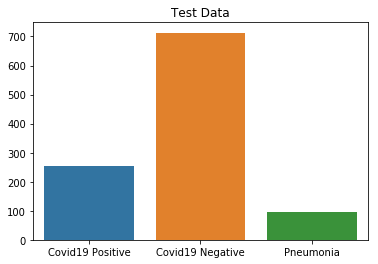

In [8]:
import seaborn as sns
my_dict = {'Covid19 Positive':'2531', 'Covid19 Negative' : '7134', 'Pneumonia' : '943'}

perc =  [float(i[:-1]) for i in my_dict.values()]
sns.barplot(x=list(my_dict.keys()),y=perc)
plt.title('Train Data')

import seaborn as sns
my_dict = {'Covid19 Positive':'1085', 'Covid19 Negative' : '3058', 'Pneumonia' : '402'}

perc =  [float(i[:-1]) for i in my_dict.values()]
sns.barplot(x=list(my_dict.keys()),y=perc)
plt.title('Test Data')


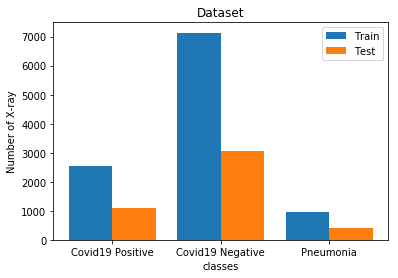

In [9]:

import numpy as np 
import matplotlib.pyplot as plt 
  
X = ['Covid19 Positive', 'Covid19 Negative', 'Pneumonia']
Ygirls = [2531,7134,943]
Zboys = [1085,3058,402]
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, Ygirls, 0.4, label = 'Train')
plt.bar(X_axis + 0.2, Zboys, 0.4, label = 'Test')
  
plt.xticks(X_axis, X)
plt.xlabel("classes")
plt.ylabel("Number of X-ray")
plt.title("Dataset")
plt.legend()
plt.show()

In [10]:
from keras.preprocessing.image import ImageDataGenerator

image_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    samplewise_center=True,
    samplewise_std_normalization=True
)

In [11]:
train = image_generator.flow_from_directory(train_dir, 
                                            batch_size=8, 
                                            shuffle=True, 
                                            class_mode='categorical',
                                            target_size=(64,64))



test = image_generator.flow_from_directory(test_dir, 
                                            batch_size=1, 
                                            shuffle=False, 
                                            class_mode='categorical',
                                            target_size=(64,64))

Found 10699 images belonging to 3 classes.
Found 4454 images belonging to 3 classes.


In [12]:
import pandas as pd


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The dimensions of the image are 64 pixels width and 64 pixels height, one single color channel.
The maximum pixel value is 2.2844 and the minimum is -2.9935
The mean value of the pixels is -0.0000 and the standard deviation is 1.0000


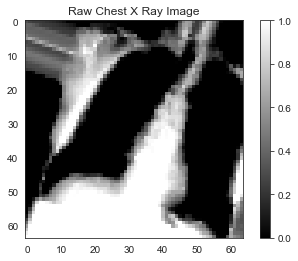

In [13]:
sns.set_style('white')
generated_image, label = train.__getitem__(0)
plt.imshow(generated_image[0], cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')

print(f"The dimensions of the image are {generated_image.shape[1]} pixels width and {generated_image.shape[2]} pixels height, one single color channel.")
print(f"The maximum pixel value is {generated_image.max():.4f} and the minimum is {generated_image.min():.4f}")
print(f"The mean value of the pixels is {generated_image.mean():.4f} and the standard deviation is {generated_image.std():.4f}")

In [14]:
# Class weights

weight_for_0 = num_Covid19_Positive / (num_Covid19_Negative + num_Covid19_Positive)
weight_for_1 = num_Covid19_Negative / (num_Covid19_Negative + num_Covid19_Positive)

class_weight = {0: weight_for_0, 1: weight_for_1}

print(f"Weight for class 0: {weight_for_0:.2f}")
print(f"Weight for class 1: {weight_for_1:.2f}")

Weight for class 0: 0.26
Weight for class 1: 0.74


In [3]:
# ResNet


In [18]:
from keras.applications import ResNet50

resnet_base_model = ResNet50(input_shape=(64,64,3), include_top=False, weights='imagenet')



In [ ]:
resnet_base_model.summary()

In [21]:
resnet_model = Sequential([
        resnet_base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation="relu"),
        BatchNormalization(),
        Dropout(0.6),
        Dense(128, activation="relu"),
        BatchNormalization(),
        Dropout(0.4),
        Dense(64,activation="relu"),
        BatchNormalization(),
        Dropout(0.3),
        Dense(3,activation="sigmoid")
    ])
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
resnet_model.compile(optimizer=opt,loss='binary_crossentropy',metrics=METRICS)

In [23]:
r = resnet_model.fit(
   train, 
    epochs=30,
    validation_data=test, 
    # class_weight=class_weight
    steps_per_epoch=300)


In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'], label='Accuracy')
plt.plot(r.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [ ]:
evaluation =resnet_model.evaluate(test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = resnet_model.evaluate(train)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

In [ ]:
model.save('resnet.h5')